### Process
1.label of emotions->one-hot encoding

2.text of each twitter->text to sequence transformation + pad the sequences to the same length.

3.model:Transformer

# Transformer

In [1]:
import nltk, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
## Hyperparameters fot tokenizer
vocab_size = 10000
maxlen = 200  # Only consider the last 200 words of each movie review


#  Using Functional API
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(8, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Data Preprocessing-Data Formation

In [ ]:
import csv
import json

data_id=[]
with open('./data_identification.csv', newline='') as csvfile:


  data = csv.reader(csvfile)
  for i in data:
    data_id.append(i)

emo=[]
with open('./emotion.csv', newline='') as csvfile:
  data = csv.reader(csvfile)
  for i in data:
    emo.append(i)

text=[]
with open("./tweets_DM.json") as file:
    for line in file.readlines():
      data=json.loads(line)
      text.append(data)



In [25]:
del(emo[0])
emo[0]
#emo is equal to train_dataset

['0x3140b1', 'sadness']

In [26]:
del(data_id[0])
train_data_id=[]
test_data_id=[]
for i,j in data_id:
    if j=='train':
        train_data_id.append(i)
    else:
        test_data_id.append(i)
print("train size:",len(train_data_id))
print("test size:",len(test_data_id))
print(train_data_id[0])

train size: 1455563
test size: 411972
0x29e452


In [27]:
text[0]

{'_score': 391,
 '_index': 'hashtag_tweets',
 '_source': {'tweet': {'hashtags': ['Snapchat'],
   'tweet_id': '0x376b20',
   'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}},
 '_crawldate': '2015-05-23 11:42:47',
 '_type': 'tweets'}

In [28]:
text[0]['_source']

{'tweet': {'hashtags': ['Snapchat'],
  'tweet_id': '0x376b20',
  'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}}

In [29]:
emo_dict={}
for tweet_id,emotion in emo:
    emo_dict[tweet_id]=emotion


In [30]:
#Parse the text.According to the tweet_id of the text:
#   if it is in train_data_id:
#       match the emo and produce train_dataset(text+label(emo[1]))
#   else:
#       produce test_datasaet(text only)

def match(tweet_id):
    return emo_dict.get(tweet_id)



train_dataset=[]
missing_data=[]
test_dataset=[]
for dict in text:
    tweet_id=dict['_source']['tweet']['tweet_id']
    score=dict['_score']
    index=dict['_index']
    hashtags=dict['_source']['tweet']['hashtags']
    text=dict['_source']['tweet']['text']
    if tweet_id  in train_data_id:
        emotion=match(tweet_id)
        if emotion!=None:
            train_dataset.append([tweet_id,score,index,hashtags,text,emotion])
        else:
            missing_data.append([tweet_id,score,index,hashtags,text])
    else:
        test_dataset.append([tweet_id,score,index,hashtags,text])



In [140]:
import pandas as pd 
train_df=pd.DataFrame(train_dataset,columns=['tweet_id','score','index','hashtags','text','emotion'])
test_df=pd.DataFrame(test_dataset,columns=['tweet_id','score','index','hashtags','text'])

In [141]:
train_df.head()


,tweet_id,score,index,hashtags,text,emotion
0,0x376b20,391,hashtag_tweets,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",anticipation
1,0x2d5350,433,hashtag_tweets,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",sadness
2,0x1cd5b0,376,hashtag_tweets,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
3,0x1d755c,120,hashtag_tweets,"[authentic, LaughOutLoud]",@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
4,0x2c91a8,1021,hashtag_tweets,[],Still waiting on those supplies Liscus. <LH>,anticipation


In [ ]:
train_df.to_csv(r'C:/Users/Neo/Desktop/DM Kaggle Competition/train_df.csv')
test_df.to_csv(r'C:/Users/Neo/Desktop/DM Kaggle Competition/test_df.csv')


In [2]:
import pandas as pd 

train_df = pd.read_csv('./train_df.csv')
test_df = pd.read_csv('./test_df.csv')


In [3]:
train_df.head()

,Unnamed: 0,tweet_id,score,index,hashtags,text,emotion
0,0,0x376b20,391,hashtag_tweets,['Snapchat'],"People who post ""add me on #Snapchat"" must be ...",anticipation
1,1,0x2d5350,433,hashtag_tweets,"['freepress', 'TrumpLegacy', 'CNN']","@brianklaas As we see, Trump is dangerous to #...",sadness
2,2,0x1cd5b0,376,hashtag_tweets,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
3,3,0x1d755c,120,hashtag_tweets,"['authentic', 'LaughOutLoud']",@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
4,4,0x2c91a8,1021,hashtag_tweets,[],Still waiting on those supplies Liscus. <LH>,anticipation


In [4]:
test_df.head()

,Unnamed: 0,tweet_id,score,index,hashtags,text
0,0,0x28b412,232,hashtag_tweets,['bibleverse'],"Confident of your obedience, I write to you, k..."
1,1,0x2de201,989,hashtag_tweets,[],"""Trust is not the same as faith. A friend is s..."
2,2,0x218443,66,hashtag_tweets,"['materialism', 'money', 'possessions']",When do you have enough ? When are you satisfi...
3,3,0x2939d5,104,hashtag_tweets,"['GodsPlan', 'GodsWork']","God woke you up, now chase the day #GodsPlan #..."
4,4,0x26289a,310,hashtag_tweets,[],"In these tough times, who do YOU turn to as yo..."


In [5]:
test_id_to_tweet_id={}
for id,tweet_id in zip(test_df['Unnamed: 0'],test_df['tweet_id']):
    test_id_to_tweet_id[id]=tweet_id

train_id_to_tweet_id={}
for id,tweet_id in zip(train_df['Unnamed: 0'],train_df['tweet_id']):
    train_id_to_tweet_id[id]=tweet_id

In [6]:
test_df=test_df.filter(items=['	Unnamed: 0','score','index','hashtags','text'])
test_df.head()

,score,index,hashtags,text
0,232,hashtag_tweets,['bibleverse'],"Confident of your obedience, I write to you, k..."
1,989,hashtag_tweets,[],"""Trust is not the same as faith. A friend is s..."
2,66,hashtag_tweets,"['materialism', 'money', 'possessions']",When do you have enough ? When are you satisfi...
3,104,hashtag_tweets,"['GodsPlan', 'GodsWork']","God woke you up, now chase the day #GodsPlan #..."
4,310,hashtag_tweets,[],"In these tough times, who do YOU turn to as yo..."


In [7]:
y_train_label=train_df.iloc[:,-1]
train_df=train_df.filter(items=['	Unnamed: 0','score','index','hashtags','text'])
test_df.head()

,score,index,hashtags,text
0,232,hashtag_tweets,['bibleverse'],"Confident of your obedience, I write to you, k..."
1,989,hashtag_tweets,[],"""Trust is not the same as faith. A friend is s..."
2,66,hashtag_tweets,"['materialism', 'money', 'possessions']",When do you have enough ? When are you satisfi...
3,104,hashtag_tweets,"['GodsPlan', 'GodsWork']","God woke you up, now chase the day #GodsPlan #..."
4,310,hashtag_tweets,[],"In these tough times, who do YOU turn to as yo..."


In [8]:
y_train_label

0          anticipation
1               sadness
2                  fear
3                   joy
4          anticipation
               ...     
1455558             joy
1455559             joy
1455560             joy
1455561             joy
1455562             joy
Name: emotion, Length: 1455563, dtype: object

# Data Preprocessing-Attribute Transformation

In [9]:
print(*y_train_label.unique())
y_label_encoding={
    'anticipation':0, 'sadness':1, 'fear':2, 'joy':3, 'anger':4, 'trust':5,
       'disgust':6, 'surprise':7
}
y_label_decoding={
    0:'anticipation', 1:'sadness', 2:'fear', 3:'joy', 4:'anger', 5:'trust',
       6:'disgust', 7:'surprise'
}

anticipation sadness fear joy anger trust disgust surprise


In [10]:
#Encode the emotion and Count the distributioon
y_label_count={
    'anticipation':0, 'sadness':0, 'fear':0, 'joy':0, 'anger':0, 'trust':0,
       'disgust':0, 'surprise':0
}
for i,j in enumerate(y_train_label):
    y_label_count[j]+=1
    y_train_label[i]=y_label_encoding[j]

print(y_train_label.head())
print(y_label_count)


0    0
1    1
2    2
3    3
4    0
Name: emotion, dtype: object
{'anticipation': 248935, 'sadness': 193437, 'fear': 63999, 'joy': 516017, 'anger': 39867, 'trust': 205478, 'disgust': 139101, 'surprise': 48729}


### Visualization
->It is obvious that the label is imbalanced.

<BarContainer object of 8 artists>

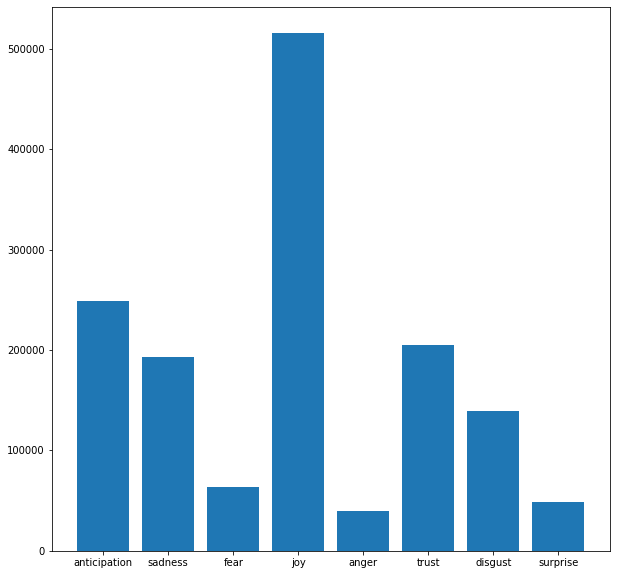

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.bar(y_label_count.keys(),y_label_count.values())

### Text to sequence transformation and one-hot encoding of emotion 

In [12]:
x_train=train_df['text']
x_test=test_df['text']

In [13]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train)
## text to sequences
texts_to_int = tokenizer.texts_to_sequences(x_train)
## pad sequences
texts_to_int_pad = keras.preprocessing.sequence.pad_sequences(texts_to_int,
                                                              maxlen=maxlen,
                                                              truncating='pre',
                                                              padding='pre')

In [14]:
texts_to_int_pad

array([[   0,    0,    0, ...,  132,  220,    1],
       [   0,    0,    0, ...,    1,    1,  610],
       [   0,    0,    0, ..., 2493,  892,    1],
       ...,
       [   0,    0,    0, ...,   49,  828,    1],
       [   0,    0,    0, ...,   16, 4296,   15],
       [   0,    0,    0, ...,   18,  424,    1]])

In [15]:
## X and y for train and val
x_train = texts_to_int_pad
y_train = y_train_label

texts_to_int2=tokenizer.texts_to_sequences(x_test)
texts_to_int_pad2 = keras.preprocessing.sequence.pad_sequences(texts_to_int2,
                                                              maxlen=maxlen,
                                                              truncating='pre',
                                                              padding='pre')
x_test=texts_to_int_pad2                                                        

In [16]:
x_train.shape

(1455563, 200)

In [17]:
x_test.shape

(411972, 200)

In [18]:
total_vocab_size = len(tokenizer.word_index) + 1

In [19]:

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_label, test_size=0.25, random_state=42)


In [20]:
def one_hot_encoder(y):
    output=[]
    for yy in y:
        if yy==0:
            output.append([1,0,0,0,0,0,0,0])
        elif yy==1:
            output.append([0,1,0,0,0,0,0,0])
        elif yy==2:
            output.append([0,0,1,0,0,0,0,0])
        elif yy==3:
            output.append([0,0,0,1,0,0,0,0])
        elif yy==4:
            output.append([0,0,0,0,1,0,0,0])
        elif yy==5:
            output.append([0,0,0,0,0,1,0,0])
        elif yy==6:
            output.append([0,0,0,0,0,0,1,0])
        elif yy==7:
            output.append([0,0,0,0,0,0,0,1])
    return np.array(output)

y_train=one_hot_encoder(y_train)
y_val=one_hot_encoder(y_val)


In [21]:
#type transformation to avoid error
x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
x_val = np.asarray(x_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
x_test = np.asarray(x_test).astype('float32')

'\ntrain_tensor= tf.data.Dataset.from_tensor_slices((x_train,y_train))\nval_tensor= tf.data.Dataset.from_tensor_slices((x_val,y_val))\ntest_tensor= tf.data.Dataset.from_tensor_slices(x_test)\n'

In [22]:
x_train.shape

(1091672, 200)

In [23]:
y_train.shape

(1091672, 8)

# Training
->I only use twitter text and emotion label to train the model.

In [26]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
8529/8529 [==============================] - 1167s 137ms/step - loss: 0.2578 - accuracy: 0.5274 - val_loss: 0.2439 - val_accuracy: 0.5491
Epoch 2/10
8529/8529 [==============================] - 1089s 128ms/step - loss: 0.2420 - accuracy: 0.5530 - val_loss: 0.2385 - val_accuracy: 0.5558
Epoch 3/10
8529/8529 [==============================] - 1070s 125ms/step - loss: 0.2361 - accuracy: 0.5636 - val_loss: 0.2355 - val_accuracy: 0.5625
Epoch 4/10
8529/8529 [==============================] - 3161s 371ms/step - loss: 0.2326 - accuracy: 0.5711 - val_loss: 0.2339 - val_accuracy: 0.5655
Epoch 5/10
8529/8529 [==============================] - 1197s 140ms/step - loss: 0.2300 - accuracy: 0.5764 - val_loss: 0.2331 - val_accuracy: 0.5680
Epoch 6/10
8529/8529 [==============================] - 1208s 142ms/step - loss: 0.2278 - accuracy: 0.5811 - val_loss: 0.2332 - val_accuracy: 0.5684
Epoch 7/10
8529/8529 [==============================] - 1209s 142ms/step - loss: 0.2261 - accuracy: 0.5852

### Checkpoint

In [27]:
#save the weights
import os
CKP_DIR_SAVE_WEIGHTS = './checkpoints_save_weights'
model.save_weights(os.path.join(CKP_DIR_SAVE_WEIGHTS, f'ckpt-{10}'))


In [28]:
#load the weights
model.load_weights('checkpoints_save_weights/ckpt-10')

# Prediction 

In [29]:
def find_max(pred_dis):
    max_id=-1
    max=0
    for id,prob in enumerate(pred_dis):
        if prob>max:
            max_id=id
            max=prob
    return max_id


In [ ]:
y_test_pred=model.predict(x_test)
emotion=[]
tweet_id=[]
for test_id,pred_dis in enumerate(y_test_pred):
    tweet_id.append(test_id_to_tweet_id[test_id])
    emotion.append(y_label_decoding[find_max(pred_dis)])

output={'id':tweet_id,'emotion':emotion}



In [33]:
output=pd.DataFrame(data=output)
output.set_index("id" , inplace=True)

output.to_csv(r'C:/Users/Neo/Desktop/DM Kaggle Competition/output_submission.csv')